In [1]:
%pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import optuna 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Download latest version
# === Download Dataset ===
# Fetch the dataset
dataset = fetch_ucirepo(id=697)
X = dataset.data.features
y = dataset.data.targets
print(f"Features shape: {X.shape}, Target shape: {y.shape}")

print(X.columns.tolist())


c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Features shape: (4424, 36), Target shape: (4424, 1)
['Marital Status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rat

In [3]:
# Simple preprocessing: encode targets and split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# After your split...
total = X.shape[0]
train_pct = X_train.shape[0] / total * 100
test_pct  = X_test.shape[0]  / total * 100

print(f"Train: {X_train.shape} ({train_pct:.1f}%), Test: {X_test.shape} ({test_pct:.1f}%)")


Train: (3539, 36), Test: (885, 36)
Train: (3539, 36) (80.0%), Test: (885, 36) (20.0%)


c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
# Train Random Forest classifier with class weighting
clf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [5]:
# Evaluate on test set
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.82      0.76      0.79       284
    Enrolled       0.59      0.35      0.44       159
    Graduate       0.79      0.94      0.86       442

    accuracy                           0.78       885
   macro avg       0.73      0.68      0.70       885
weighted avg       0.76      0.78      0.76       885

Confusion Matrix:
[[216  23  45]
 [ 38  56  65]
 [ 10  16 416]]


In [6]:
import contextlib
import optuna.logging as logging

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 0) Set Optuna logging
logging.set_verbosity(logging.INFO)

# 1) Prepare data
# Replace the next two lines with your actual X, y loading
# Example:
# from ucimlrepo import fetch_ucirepo
# ds = fetch_ucirepo(id=697)
# X_raw, y_raw = ds.data.features, ds.data.targets

# For now assume X and y already in scope:
y = LabelEncoder().fit_transform(y)
X_scaled = StandardScaler().fit_transform(X)

# 2) Define objectives

def objective_lgbm(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 15, 100)
    }
    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_scaled, y, cv=3, scoring='f1_macro').mean()
    trial.report(score, step=0)
    return score

def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0)
    }
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **params)
    score = cross_val_score(model, X_scaled, y, cv=3, scoring='f1_macro').mean()
    trial.report(score, step=0)
    return score

# 3) Create studies
study_lgbm = optuna.create_study(direction='maximize')
study_xgb  = optuna.create_study(direction='maximize')

# 4) Run tuning with logs redirected to disk
with open('lgbm_optuna.log', 'w') as log_f:
    with contextlib.redirect_stdout(log_f), contextlib.redirect_stderr(log_f):
        study_lgbm.optimize(objective_lgbm, n_trials=30, show_progress_bar=True)

with open('xgb_optuna.log', 'w') as log_f:
    with contextlib.redirect_stdout(log_f), contextlib.redirect_stderr(log_f):
        study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

# 5) Save concise summary
with open('optuna_summary.txt', 'w') as summary:
    summary.write("=== LightGBM Tuning Results ===\n")
    summary.write(f"Best f1_macro:  {study_lgbm.best_value:.6f}\n")
    summary.write(f"Best hyperparams: {study_lgbm.best_params}\n\n")
    summary.write("=== XGBoost Tuning Results ===\n")
    summary.write(f"Best f1_macro:  {study_xgb.best_value:.6f}\n")
    summary.write(f"Best hyperparams: {study_xgb.best_params}\n")

# 6) Display only the summary in the notebook
print(open('optuna_summary.txt').read())

# 7) Instantiate best models for downstream use
best_lgbm = LGBMClassifier(**study_lgbm.best_params)
best_xgb  = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **study_xgb.best_params)
best_cat  = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.05, verbose=0)

# Optional: show top 5 LightGBM trials as a sanity check
print("\nLightGBM top trials:")
print(study_lgbm.trials_dataframe().sort_values("value", ascending=False).head())


c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-04-27 15:49:46,137] A new study created in memory with name: no-name-dab0ba28-3158-477a-b06e-5e2d9a493607
[I 2025-04-27 15:49:46,138] A new study created in memory with name: no-name-d8c9e2c9-6980-4ba3-ab33-abde57cdb7ae


=== LightGBM Tuning Results ===
Best f1_macro:  0.709973
Best hyperparams: {'max_depth': 6, 'learning_rate': 0.17101606228470917, 'n_estimators': 1460, 'reg_alpha': 4.139299020802825, 'reg_lambda': 4.44827433784963, 'subsample': 0.6944164400859852, 'colsample_bytree': 0.46683471803396814, 'num_leaves': 30}

=== XGBoost Tuning Results ===
Best f1_macro:  0.711564
Best hyperparams: {'max_depth': 3, 'learning_rate': 0.061687827695399454, 'n_estimators': 573, 'gamma': 1.0423094991202213, 'min_child_weight': 1, 'subsample': 0.7248523338890562, 'colsample_bytree': 0.7272322812627775}


LightGBM top trials:
    number     value             datetime_start          datetime_complete  \
19      19  0.709973 2025-04-27 15:50:29.954417 2025-04-27 15:50:31.158096   
18      18  0.709692 2025-04-27 15:50:28.704414 2025-04-27 15:50:29.953417   
5        5  0.708584 2025-04-27 15:49:55.208188 2025-04-27 15:49:57.549788   
21      21  0.708266 2025-04-27 15:50:32.121096 2025-04-27 15:50:33.605735   
28

In [7]:
from contextlib import redirect_stdout, redirect_stderr
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

# === StratifiedKFold CV with Voting Ensemble (logs → ensemble_logs.txt) ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_preds = []
all_true = []

with open('ensemble_logs.txt', 'w') as log_file:
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled, y), start=1):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        ensemble = VotingClassifier(
            estimators=[
                ('lgbm', best_lgbm),
                ('xgb',  best_xgb),
                ('cat',  best_cat)
            ],
            voting='soft'
        )

        # Redirect all verbose model output into ensemble_logs.txt
        with redirect_stdout(log_file), redirect_stderr(log_file):
            ensemble.fit(X_train, y_train)
            preds = ensemble.predict(X_val)

        # Collect & print only the fold accuracy
        all_preds.extend(preds)
        all_true.extend(y_val)
        print(f"Fold {fold} Accuracy: {accuracy_score(y_val, preds):.4f}")

# === Final Evaluation (printed in -notebook) ===
print("\n=== Overall Performance ===")
print(classification_report(all_true, all_preds, target_names=le.classes_))


Fold 1 Accuracy: 0.7910
Fold 2 Accuracy: 0.7763
Fold 3 Accuracy: 0.7774
Fold 4 Accuracy: 0.7763
Fold 5 Accuracy: 0.7726

=== Overall Performance ===
              precision    recall  f1-score   support

     Dropout       0.82      0.77      0.79      1421
    Enrolled       0.57      0.40      0.47       794
    Graduate       0.80      0.92      0.86      2209

    accuracy                           0.78      4424
   macro avg       0.73      0.70      0.71      4424
weighted avg       0.77      0.78      0.77      4424



c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


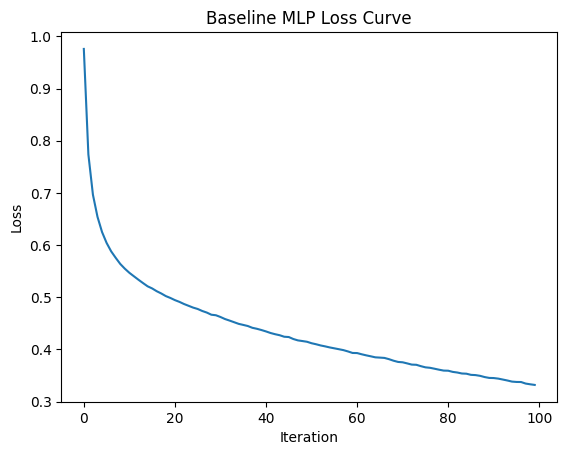

In [8]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# 1) Train a simple MLP
mlp = MLPClassifier(random_state=42, max_iter=100, verbose=False)
mlp.fit(X_train, y_train)

# 2) Plot the loss over iterations
plt.figure()
plt.plot(mlp.loss_curve_)
plt.title("Baseline MLP Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Baseline MLP Test Accuracy: 0.718

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.76      0.69      0.72       284
    Enrolled       0.40      0.40      0.40       159
    Graduate       0.80      0.85      0.83       442

    accuracy                           0.72       885
   macro avg       0.65      0.65      0.65       885
weighted avg       0.72      0.72      0.72       885



c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


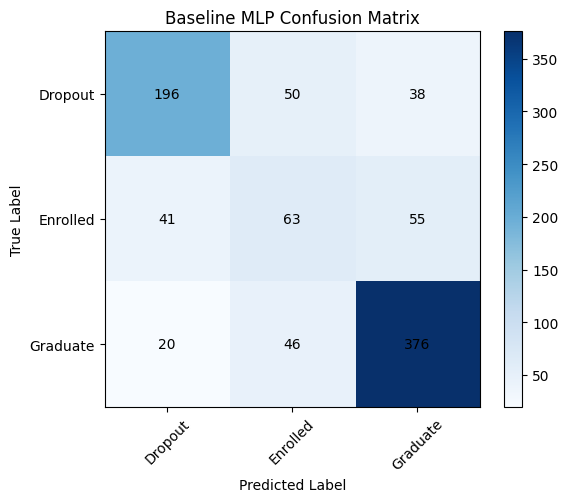

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# 1) Fetch the dataset
dataset = fetch_ucirepo(id=697)
X = dataset.data.features
y = dataset.data.targets

# 2) Encode labels to integers
le = LabelEncoder().fit(y)
y_enc = le.transform(y)

# 3) Scale features
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# 4) Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# 5) Train baseline MLP
mlp = MLPClassifier(random_state=42, max_iter=200)
mlp.fit(X_train, y_train)

# 6) Predict & print metrics
y_pred = mlp.predict(X_test)
print(f"Baseline MLP Test Accuracy: {accuracy_score(y_test, y_pred):.3f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 7) Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Baseline MLP Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
ticks = np.arange(len(le.classes_))
plt.xticks(ticks, le.classes_, rotation=45)
plt.yticks(ticks, le.classes_)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.colorbar()
plt.tight_layout()
plt.show()


In [13]:
print(X.columns.tolist())


['Marital Status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']


In [18]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

# 1) Make sure you’ve fetched and prepped X, y_raw:
ds = fetch_ucirepo(id=697)
X = ds.data.features
y_raw = ds.data.targets

# 2) Build DataFrame
df = X.copy()
df['Target'] = y_raw

# 3) Crosstab counts
counts = pd.crosstab(df['Gender'], df['Target'])
print("Raw counts by gender and outcome:\n", counts)

# 4) Normalize to rates
rates = counts.div(counts.sum(axis=1), axis=0)

# 5) Show code distribution
print("\nGender code distribution:")
print(df['Gender'].value_counts())

# 6) Map codes to labels (0→Male, 1→Female) and reprint
gender_map = {0: 'Male', 1: 'Female'}
counts_named = counts.rename(index=gender_map)
rates_named = rates.rename(index=gender_map)

print("\nCounts by labeled gender and outcome:\n", counts_named)
print("\nDropout rate by gender (as fraction of each gender):")
print(rates_named['Dropout'].rename("Dropout Rate"))

# … after you’ve computed `counts_named` and `rates_named` …

# 7) Compute and display percentages
dropout_pct = (rates_named['Dropout'] * 100).round(2).astype(str) + '%'

print("\nDropout percentage by gender:")
print(dropout_pct)

# 8) Or as a small summary table:
summary = pd.DataFrame({
    'Dropout Count': counts_named['Dropout'],
    'Dropout Rate': rates_named['Dropout'].round(4),       # fraction
    'Dropout %': dropout_pct                                # percentage string
})
print("\nSummary table:")
print(summary)



Raw counts by gender and outcome:
 Target  Dropout  Enrolled  Graduate
Gender                             
0           720       487      1661
1           701       307       548

Gender code distribution:
Gender
0    2868
1    1556
Name: count, dtype: int64

Counts by labeled gender and outcome:
 Target  Dropout  Enrolled  Graduate
Gender                             
Male        720       487      1661
Female      701       307       548

Dropout rate by gender (as fraction of each gender):
Gender
Male      0.251046
Female    0.450514
Name: Dropout Rate, dtype: float64

Dropout percentage by gender:
Gender
Male       25.1%
Female    45.05%
Name: Dropout, dtype: object

Summary table:
        Dropout Count  Dropout Rate Dropout %
Gender                                       
Male              720        0.2510     25.1%
Female            701        0.4505    45.05%


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the raw Gender column
X_gend = df[['Gender']]
y_enc = LabelEncoder().fit_transform(df['Target'])
Xg_train, Xg_test, yg_train, yg_test = train_test_split(
    X_gend, y_enc, stratify=y_enc, test_size=0.2, random_state=42
)

# Train multinomial LR
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(Xg_train, yg_train)
yg_pred = lr.predict(Xg_test)

print("Gender-only model performance:")
print(classification_report(yg_test, yg_pred, target_names=le.classes_))


Gender-only model performance:
              precision    recall  f1-score   support

     Dropout       0.46      0.51      0.48       284
    Enrolled       0.00      0.00      0.00       159
    Graduate       0.58      0.75      0.65       442

    accuracy                           0.54       885
   macro avg       0.35      0.42      0.38       885
weighted avg       0.44      0.54      0.48       885



c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

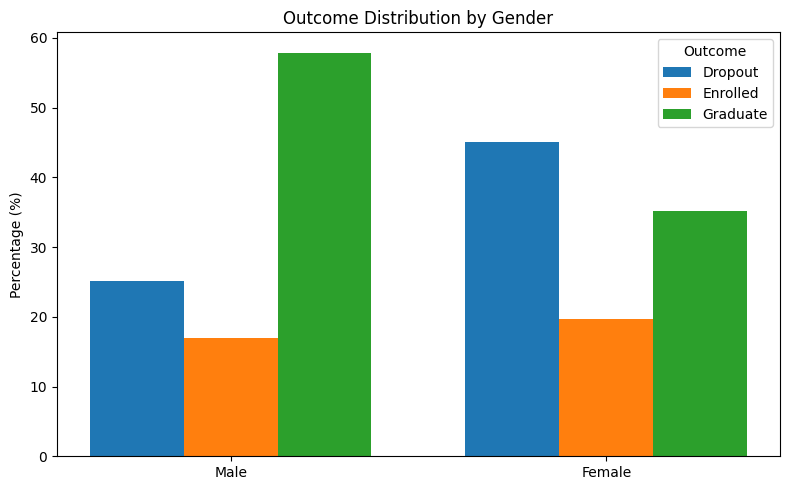

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Assume X (DataFrame of features) and y_raw (Series of 'Dropout'/'Enrolled'/'Graduate') are already defined
#    and that X['Gender'] holds 0/1 codes.

# 2) Build a small DataFrame
df = X.copy()
df['Target'] = y_raw

# 3) Compute counts and convert to percentages
counts = pd.crosstab(df['Gender'], df['Target'])
rates = counts.div(counts.sum(axis=1), axis=0) * 100

# 4) (Optional) Map numeric codes to labels
gender_map = {0: 'Male', 1: 'Female'}
rates.index = rates.index.map(gender_map)

# 5) Plot
fig, ax = plt.subplots(figsize=(8,5))
outcomes = rates.columns.tolist()
x = np.arange(len(rates.index))
width = 0.25

for i, outcome in enumerate(outcomes):
    ax.bar(x + (i-1)*width, rates[outcome], width, label=outcome)

ax.set_xticks(x)
ax.set_xticklabels(rates.index)
ax.set_ylabel('Percentage (%)')
ax.set_title('Outcome Distribution by Gender')
ax.legend(title='Outcome')
plt.tight_layout()
plt.show()


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# 1) Build X_gender, y_multi
X_gender = X[['Gender']]               # DataFrame with just the Gender column
y_multi  = y_raw                       # same three‐class target

# 2) Encode y and split
le_multi = LabelEncoder().fit(y_multi)
y_enc    = le_multi.transform(y_multi)
Xg_train, Xg_test, yg_train, yg_test = train_test_split(
    X_gender, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# 3) Train a multinomial logistic regression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
lr.fit(Xg_train, yg_train)

# 4) Predict & evaluate
yg_pred = lr.predict(Xg_test)
print("Gender‐Only Classifier Accuracy:", accuracy_score(yg_test, yg_pred))
print(classification_report(yg_test, yg_pred, target_names=le_multi.classes_))


Gender‐Only Classifier Accuracy: 0.536723163841808
              precision    recall  f1-score   support

     Dropout       0.46      0.51      0.48       284
    Enrolled       0.00      0.00      0.00       159
    Graduate       0.58      0.75      0.65       442

    accuracy                           0.54       885
   macro avg       0.35      0.42      0.38       885
weighted avg       0.44      0.54      0.48       885



c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\brizz\AppData\Local\Programs\Python\Python312\Lib

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1) Extract GPA target
gpa1 = ds.data.features['Curricular units 1st sem (grade)']  # numeric column

# 2) Split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_scaled, gpa1, test_size=0.2, random_state=42
)

# 3) Train RF regressor
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(Xr_train, yr_train)

# 4) Predict & evaluation
yr_pred = rf_reg.predict(Xr_test)
print("MSE:", mean_squared_error(yr_test, yr_pred))
print("R²  :", r2_score(yr_test, yr_pred))


MSE: 0.0015462006760796284
R²  : 0.9999335283703452
